
# Performance & Reliability Testing of AI4NE & NE4AI LLM Agents
Author: Niccolò Caselli

This notebook contains a suite of tools and experiments designed to assess the performance, reliability, and accuracy of various Large Language Model (LLM) services. It is used to perform the empirical experiment described in Chapter 3 of my thesis, focusing on the integration of AI for Networking (AI4NE) and Networking for AI (NE4AI) paradigms.

Import Libraries

In [1]:
from random import shuffle
import requests
import time
import matplotlib.pyplot as plt
from collections import Counter
import csv
from typing import List, Dict, Any, Optional, Callable
from dataclasses import dataclass
from enum import Enum
from typing import Tuple

This cell defines the core classes for conducting performance and reliability tests: ResultStatus (an Enum for test outcomes), TestCaseResult (a dataclass to store individual test results), Test (a class for defining and running a single test scenario against an endpoint), and Experiment (a class to manage and run multiple tests, along with plotting and summary functionalities).

In [3]:
class ResultStatus(Enum):
    PASSED = "PASSED"
    FAILED = "FAILED"
    ERROR = "ERROR"


@dataclass
class TestCaseResult:
    status: ResultStatus
    response_time_ms: Optional[float]
    http_status_code: Optional[int]
    data: Optional[Dict[str, Any]]
    error_message: Optional[str]
    timestamp: float

    def __post_init__(self):
        if self.timestamp is None:
            self.timestamp = time.time()

    @property
    def is_successful(self) -> bool:
        return self.status == ResultStatus.PASSED

    @property
    def is_error(self) -> bool:
        return self.status == ResultStatus.ERROR

    def to_dict(self) -> Dict[str, Any]:
        return {
            "time": self.response_time_ms,
            "result": self.status.value,
            "http_status": self.http_status_code,
            "error_message": self.error_message,
            "timestamp": self.timestamp
        }


class Test:
    def __init__(self,
                 name: str,
                 endpoint: str,
                 request_text: str,
                 validator: Callable[[Dict[str, Any]], ResultStatus],
                 num_requests: int = 20,
                 num_warmup_requests: int = 1,
                 request_timeout: int = 30,
                additional_payload: Optional[Dict[str, Any]] = None
                 ):
        self.name = name
        self.endpoint = endpoint
        self.request_payload = request_text
        self.validator = validator
        self.results: List[TestCaseResult] = []

        # Request configuration
        self.num_requests = num_requests
        self.num_warmup_requests = num_warmup_requests
        self.request_timeout = request_timeout
        self.headers = {
            "Content-Type": "application/json",
            "Accept": "application/json"
        }
        self.additional_payload = additional_payload if additional_payload is not None else {}

        # Retry configuration
        self.initial_delay = 20
        self.max_delay = 100
        self.step_delay = 10

    def _send_request(self, payload: Dict[str, Any]) -> TestCaseResult:
        start_time = time.perf_counter()

        try:
            response = requests.post(
                self.endpoint,
                json=payload,
                headers=self.headers,
                timeout=self.request_timeout
            )
            end_time = time.perf_counter()
            response_time_ms = (end_time - start_time) * 1000

            response.raise_for_status()
            data = response.json() if response.content else None

            # Check if data is empty
            # (e.g., rate limiter error)
            if not data:
                return TestCaseResult(
                    status=ResultStatus.ERROR,
                    response_time_ms=response_time_ms,
                    http_status_code=response.status_code,
                    data=None,
                    error_message="Empty data returned",
                    timestamp=time.time()
                )

            return TestCaseResult(
                status=ResultStatus.PASSED,
                response_time_ms=response_time_ms,
                http_status_code=response.status_code,
                data=data,
                error_message=None,
                timestamp=time.time()
            )

        except requests.exceptions.Timeout:
            end_time = time.perf_counter()
            response_time_ms = (end_time - start_time) * 1000
            return TestCaseResult(
                status=ResultStatus.ERROR,
                response_time_ms=response_time_ms,
                http_status_code=None,
                data=None,
                error_message="Request timed out",
                timestamp=time.time()
            )

        except requests.exceptions.ConnectionError as e:
            return TestCaseResult(
                status=ResultStatus.ERROR,
                response_time_ms=None,
                http_status_code=None,
                data=None,
                error_message=f"Connection error: {e}",
                timestamp=time.time()
            )

        except requests.exceptions.RequestException as e:
            end_time = time.perf_counter()
            response_time_ms = (end_time - start_time) * 1000
            return TestCaseResult(
                status=ResultStatus.ERROR,
                response_time_ms=response_time_ms,
                http_status_code=getattr(e.response, 'status_code', None) if hasattr(e, 'response') else None,
                data=None,
                error_message=f"Request failed: {e}",
                timestamp=time.time()
            )

        except Exception as e:
            return TestCaseResult(
                status=ResultStatus.ERROR,
                response_time_ms=None,
                http_status_code=None,
                data=None,
                error_message=f"Unexpected error: {e}",
                timestamp=time.time()
            )

    def _execute_test_case(self) -> TestCaseResult:
        payload = {"request": self.request_payload, "observability":False }
        # Merge the additional_payload into the base payload
        payload.update(self.additional_payload)

        result = self._send_request(payload)

        if result.status == ResultStatus.PASSED:
            # Validate the response
            validation = self.validator(result.data)
            if validation == ResultStatus.PASSED:
                print(f"✓ Valid response [{result.data}]")
                return result

            elif validation == ResultStatus.FAILED:
                print(f"✗ Invalid response [{result.data}]")
                return TestCaseResult(
                    status=ResultStatus.FAILED,
                    response_time_ms=result.response_time_ms,
                    http_status_code=result.http_status_code,
                    data=result.data,
                    error_message="Response validation failed",
                    timestamp=result.timestamp
                )

            else:
                # Probably due to rate limiter
                print(f" EMPTY response [{result.data}]")
                return TestCaseResult(
                    status=ResultStatus.ERROR,
                    response_time_ms=result.response_time_ms,
                    http_status_code=result.http_status_code,
                    data=result.data,
                    error_message="Empty response",
                    timestamp=result.timestamp
                )
        else:
            print(f"✗ Request failed: {result.error_message}")
            return result

    def _run_warmup(self):
        print(f"Starting warmup phase ({self.num_warmup_requests} requests)...")
        for i in range(self.num_warmup_requests):
            print(f"Warmup {i+1}/{self.num_warmup_requests}")
            self._execute_test_case()
        print("✓ Warmup phase complete.\n")

    def run(self) -> List[TestCaseResult]:
        """Execute the complete test suite."""
        print(f"- Starting test: {self.name}")
        print(f"- Endpoint: {self.endpoint}")
        print(f"- Request: {self.request_payload}")
        print("=" * 80)

        self.results.clear()

        # Run warmup
        self._run_warmup()

        # Run actual tests
        print(f"Starting test phase ({self.num_requests} successful requests targeted)...")

        requests_made = 0
        current_delay = self.initial_delay

        while requests_made < self.num_requests:
            print(f"Request {requests_made + 1}/{self.num_requests}")

            try:
                result = self._execute_test_case()

                if result.status in [ResultStatus.PASSED, ResultStatus.FAILED]:
                    self.results.append(result)
                    requests_made += 1
                    current_delay = self.initial_delay
                    time.sleep(self.step_delay)
                else:
                    print(f"⚠ Error encountered. Retrying after {current_delay:.2f} seconds...")
                    time.sleep(current_delay)
                    current_delay = min(current_delay * 2, self.max_delay)

            except Exception as e:
                print(f"⚠ Unexpected error: {e}. Retrying after {current_delay:.2f} seconds...")
                time.sleep(current_delay)
                current_delay = min(current_delay * 2, self.max_delay)

        self._print_summary()
        return self.results

    def _print_summary(self):
        """Print test execution summary."""
        passed_count = sum(1 for r in self.results if r.status == ResultStatus.PASSED)
        failed_count = sum(1 for r in self.results if r.status == ResultStatus.FAILED)

        execution_times = [r.response_time_ms for r in self.results if r.response_time_ms is not None]
        avg_time = sum(execution_times) / len(execution_times) if execution_times else 0

        print("\n" + "="*80)
        print(f"Test Summary for: {self.name}")
        print(f"- PASSED: {passed_count}")
        print(f"- FAILED: {failed_count}")
        print(f"- Total: {len(self.results)}")
        print(f"- Average Response Time: {avg_time:.2f} ms")
        print(f"- Success Rate: {(passed_count/len(self.results)*100):.1f}%" if self.results else "N/A")
        print("="*80)

    def save_results(self, filename: str):
        if not self.results:
            print("No results to save.")
            return

        try:
            with open(filename, 'w', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=['time', 'result', 'http_status', 'error_message', 'timestamp'])
                writer.writeheader()
                writer.writerows([result.to_dict() for result in self.results])
            print(f"Results saved to {filename}")
        except IOError as e:
            print(f"Error saving results: {e}")

    def get_metrics(self) -> Dict[str, Any]:
        if not self.results:
            return {}

        times = [r.response_time_ms for r in self.results if r.response_time_ms is not None]
        passed_count = sum(1 for r in self.results if r.status == ResultStatus.PASSED)

        return {
            'name': self.name,
            'total_requests': len(self.results),
            'passed_requests': passed_count,
            'failed_requests': len(self.results) - passed_count,
            'success_rate': passed_count / len(self.results) if self.results else 0,
            'avg_response_time': sum(times) / len(times) if times else 0,
            'min_response_time': min(times) if times else 0,
            'max_response_time': max(times) if times else 0,
            'median_response_time': np.median(times) if times else 0
        }

    def plot_performance_and_reliability(self):
        if not self.results:
            print("No results to plot.")
            return

        # Extract times and result labels
        times = np.array([r.response_time_ms for r in self.results if r.response_time_ms is not None])
        labels = [r.status.value for r in self.results]

        if len(times) == 0:
            print("No valid response times to plot.")
            return

        fig, axs = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle(f"Performance & Reliability Analysis: {self.name}", fontsize=16)

        # Execution Time Line Plot
        axs[0, 0].plot(times, marker='o', linestyle='-', color='blue')
        axs[0, 0].set_title("Execution Time Over Runs")
        axs[0, 0].set_xlabel("Run Index")
        axs[0, 0].set_ylabel("Time (ms)")
        axs[0, 0].grid(True)

        # Execution Time Boxplot
        axs[0, 1].boxplot(times, vert=True)
        axs[0, 1].set_title("Execution Time Boxplot")
        axs[0, 1].set_ylabel("Time (ms)")

        # Execution Time Histogram
        axs[0, 2].hist(times, bins=20, color='skyblue', edgecolor='black')
        axs[0, 2].set_title("Execution Time Histogram")
        axs[0, 2].set_xlabel("Time (ms)")
        axs[0, 2].set_ylabel("Frequency")

        # Cumulative Success Rate
        success_flags = np.array([1 if r == "PASSED" else 0 for r in labels])
        cum_success = np.cumsum(success_flags)
        cum_total = np.arange(1, len(self.results) + 1)
        cum_success_rate = cum_success / cum_total

        axs[1, 0].plot(cum_success_rate, color='green')
        axs[1, 0].set_title("Cumulative Success Rate")
        axs[1, 0].set_xlabel("Run Index")
        axs[1, 0].set_ylabel("Success Rate")
        axs[1, 0].set_ylim(0, 1.05)
        axs[1, 0].grid(True)

        # Reliability Histogram (Count of each result)
        result_counts = Counter(labels)
        result_names, result_values = zip(*result_counts.items())
        axs[1, 1].bar(result_names, result_values, color='orange')
        axs[1, 1].set_title("Result Counts")
        axs[1, 1].set_ylabel("Occurrences")

        # Hide empty subplot
        axs[1, 2].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()



class Experiment:
    def __init__(self, name: str):
        self.name = name
        self.tests: List[Test] = []

    def add_test(self, test: Test):
        self.tests.append(test)

    def run_all_tests(self) -> Dict[str, List[TestCaseResult]]:
        print(f"Starting Experiment: {self.name}")
        print(f"Running {len(self.tests)} tests")
        print("="*100)

        results = {}
        for i, test in enumerate(self.tests, 1):
            print(f"\nTest {i}/{len(self.tests)}: {test.name}")
            print("-" * 60)
            test_results = test.run()
            results[test.name] = test_results
            print(f"✓ Test {test.name} completed")

        print(f"\nExperiment '{self.name}' completed!")
        self._print_experiment_summary()
        return results

    def _print_experiment_summary(self):
        """Print overall experiment summary."""
        print("\n" + "="*100)
        print(f"🧪 EXPERIMENT SUMMARY: {self.name}")
        print("="*100)

        for test in self.tests:
            metrics = test.get_metrics()
            if metrics:
                print(f" {metrics['name']}:")
                print(f" - Success Rate: {metrics['success_rate']*100:.1f}%")
                print(f" - Avg Response Time: {metrics['avg_response_time']:.2f}ms")
                print(f" - Total Requests: {metrics['total_requests']}")
                print()


    def plot_single_tests(self):
        if not self.tests:
            print("No tests to plot.")
            return

        for test in self.tests:
            if test.results:
                test.plot_performance_and_reliability()


    def plot_comparison(self):
        if not self.tests:
            print("No tests to plot.")
            return

        test_data = []
        for test in self.tests:
            if test.results:
                results_dict = [result.to_dict() for result in test.results]
                test_data.append((results_dict, test.name))

        if test_data:
            self._plot_flexible_test_comparison(test_data)
        else:
            print("No test results available for plotting.")

    def _plot_flexible_test_comparison(self, test_data):
        if not test_data:
            print("No test data provided. Nothing to plot.")
            return

        times_all = []
        cum_success_rates_all = []
        result_counts_all = []
        all_labels = []
        all_possible_results = set()

        colors = plt.colormaps['tab10']

        for i, (results, label) in enumerate(test_data):
            if not results:
                continue

            times = np.array([entry["time"] for entry in results if entry["time"] is not None])
            result_labels = [entry["result"] for entry in results]

            times_all.append(times)
            all_labels.append(label)

            # Calculate Cumulative Success Rate
            success_flags = np.array([1 if r == "PASSED" else 0 for r in result_labels])
            cum_success = np.cumsum(success_flags)
            cum_total = np.arange(1, len(results) + 1)
            cum_success_rate = cum_success / cum_total
            cum_success_rates_all.append(cum_success_rate)

            # Count results for reliability histogram
            counts = Counter(result_labels)
            result_counts_all.append(counts)
            all_possible_results.update(counts.keys())

        if not all_labels:
            print("All provided tests had no data. Nothing to plot.")
            return

        all_possible_results = sorted(list(all_possible_results))

        fig, axs = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f"Performance & Reliability Comparison: {self.name}", fontsize=18)

        # Execution Time Line Plot
        ax_line = axs[0, 0]
        for i, times in enumerate(times_all):
            ax_line.plot(times, marker='o', linestyle='-', color=colors(i), label=all_labels[i])
        ax_line.set_title("Execution Time Over Runs")
        ax_line.set_xlabel("Run Index")
        ax_line.set_ylabel("Time (ms)")
        ax_line.grid(True)
        ax_line.legend()

        # Execution Time Boxplot
        ax_boxplot = axs[0, 1]
        if times_all:
            ax_boxplot.boxplot(times_all, vert=True, labels=all_labels, patch_artist=True)
            for patch, color in zip(ax_boxplot.artists, [colors(i) for i in range(len(times_all))]):
                patch.set_facecolor(color)
        ax_boxplot.set_title("Execution Time Boxplot Comparison")
        ax_boxplot.set_ylabel("Time (ms)")
        ax_boxplot.tick_params(axis='x', rotation=45)
        ax_boxplot.grid(True, axis='y')

        # Cumulative Success Rate
        ax_cum_success = axs[1, 0]
        for i, cum_rate in enumerate(cum_success_rates_all):
            ax_cum_success.plot(cum_rate, color=colors(i), label=all_labels[i])
        ax_cum_success.set_title("Cumulative Success Rate Comparison")
        ax_cum_success.set_xlabel("Run Index")
        ax_cum_success.set_ylabel("Success Rate")
        ax_cum_success.set_ylim(0, 1.05)
        ax_cum_success.grid(True)
        ax_cum_success.legend()

        # Reliability Histogram (Grouped Bar Chart)
        ax_reliability = axs[1, 1]
        x = np.arange(len(all_possible_results))
        bar_width = 0.8 / len(all_labels) if len(all_labels) > 0 else 0.8

        for i, (counts, label) in enumerate(zip(result_counts_all, all_labels)):
            values = [counts.get(res, 0) for res in all_possible_results]
            offset = i * bar_width - (len(all_labels) - 1) * bar_width / 2
            ax_reliability.bar(x + offset, values, bar_width, label=label, color=colors(i), alpha=0.7)

        ax_reliability.set_title("Result Counts Comparison")
        ax_reliability.set_ylabel("Occurrences")
        ax_reliability.set_xticks(x)
        ax_reliability.set_xticklabels(all_possible_results)
        ax_reliability.tick_params(axis='x', rotation=45)
        ax_reliability.legend()
        ax_reliability.grid(True, axis='y')

        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.show()

    def export_all_results(self, base_filename: str):
        for test in self.tests:
            filename = f"{base_filename}_{test.name.replace(' ', '_').lower()}.csv"
            test.save_results(filename)

This cell sets up global constants for the experiment. It also defines the NetworkExperiment class, which orchestrates the testing of various services endpoints against a specific request and expected answer, including a validation method.

In [4]:
COGNITIVE_WORKFLOW_URL = "http://localhost:3001/api/workflows/execute"
SIMPLE_LLM_URL = "http://localhost:3002/ai4ne/simple_llm"
FUNCTION_CALLING_LLM_URL = "http://localhost:3002/ai4ne/function_calling"

WARMUP_REQUESTS = 1
REQUEST_TIMEOUT = 30


class NetworkExperiment:
    def __init__(self, test_name:str, request_text:str, expected_answer: any, num_requests: int, num_warmup_requests:int = WARMUP_REQUESTS):

        self.expected_answer = expected_answer

        self.experiment = Experiment(test_name)

        cognitive_test = Test(
            name="Cognitive Workflow",
            endpoint=COGNITIVE_WORKFLOW_URL,
            request_text=request_text,
            validator=self.is_valid_answer,
            num_requests=num_requests,
            num_warmup_requests=num_warmup_requests,
            request_timeout=REQUEST_TIMEOUT
        )
        self.experiment.add_test(cognitive_test)

        simple_llm_test = Test(
            name="Simple LLM",
            endpoint=SIMPLE_LLM_URL,
            request_text=request_text,
            validator=self.is_valid_answer,
            num_requests=num_requests,
             num_warmup_requests=num_warmup_requests,
            request_timeout=REQUEST_TIMEOUT
        )
        self.experiment.add_test(simple_llm_test)


        function_calling_test = Test(
            name="Function Calling LLM",
            endpoint=FUNCTION_CALLING_LLM_URL,
            request_text=request_text,
            validator=self.is_valid_answer,
            num_requests=num_requests,
            num_warmup_requests=num_warmup_requests,
            request_timeout=REQUEST_TIMEOUT
        )
        self.experiment.add_test(function_calling_test)


    def is_valid_answer(self, answer: dict):
        if not answer:
            return ResultStatus.ERROR

        path = answer.get("path") or answer.get("selectedPath")

        if path == []: #  Probably a rate limiter error
            return ResultStatus.FAILED

        if path is None:
            return ResultStatus.FAILED

        if path != self.expected_answer:
            return ResultStatus.FAILED

        return ResultStatus.PASSED

# Test 1A: Mobile Device Traffic Routing


In [40]:
REQUEST_TEXT = "Route mobile device traffic that requires 5G Advanced connectivity with mmWave support and AI-enhanced signal edge processing"
RIGHT_ANSWER = ["1", "2", "4", "5"]

networkExperiment = NetworkExperiment("Test 1A", REQUEST_TEXT, RIGHT_ANSWER, 20)
networkExperiment.experiment.run_all_tests()

Starting Experiment: Test 1A
Running 3 tests

Test 1/3: Cognitive Workflow
------------------------------------------------------------
- Starting test: Cognitive Workflow
- Endpoint: http://localhost:3001/api/workflows/execute
- Request: Route mobile device traffic that requires 5G Advanced connectivity with mmWave support and AI-enhanced signal edge processing
Starting warmup phase (1 requests)...
Warmup 1/1
✓ Valid response [{'path': ['1', '2', '4', '5']}]
✓ Warmup phase complete.

Starting test phase (20 successful requests targeted)...
Request 1/20
✓ Valid response [{'path': ['1', '2', '4', '5']}]
Request 2/20
✓ Valid response [{'path': ['1', '2', '4', '5']}]
Request 3/20
✓ Valid response [{'path': ['1', '2', '4', '5']}]
Request 4/20
✓ Valid response [{'path': ['1', '2', '4', '5']}]
Request 5/20
✓ Valid response [{'path': ['1', '2', '4', '5']}]
Request 6/20
✓ Valid response [{'path': ['1', '2', '4', '5']}]
Request 7/20
✓ Valid response [{'path': ['1', '2', '4', '5']}]
Request 8/20

{'Cognitive Workflow': [TestCaseResult(status=<ResultStatus.PASSED: 'PASSED'>, response_time_ms=10631.1814590008, http_status_code=200, data={'path': ['1', '2', '4', '5']}, error_message=None, timestamp=1751130925.908181),
  TestCaseResult(status=<ResultStatus.PASSED: 'PASSED'>, response_time_ms=9282.314416996087, http_status_code=200, data={'path': ['1', '2', '4', '5']}, error_message=None, timestamp=1751130945.213387),
  TestCaseResult(status=<ResultStatus.PASSED: 'PASSED'>, response_time_ms=10422.240457999578, http_status_code=200, data={'path': ['1', '2', '4', '5']}, error_message=None, timestamp=1751130965.645409),
  TestCaseResult(status=<ResultStatus.PASSED: 'PASSED'>, response_time_ms=8006.279374996666, http_status_code=200, data={'path': ['1', '2', '4', '5']}, error_message=None, timestamp=1751130983.6592782),
  TestCaseResult(status=<ResultStatus.PASSED: 'PASSED'>, response_time_ms=8828.275874999235, http_status_code=200, data={'path': ['1', '2', '4', '5']}, error_message=Non

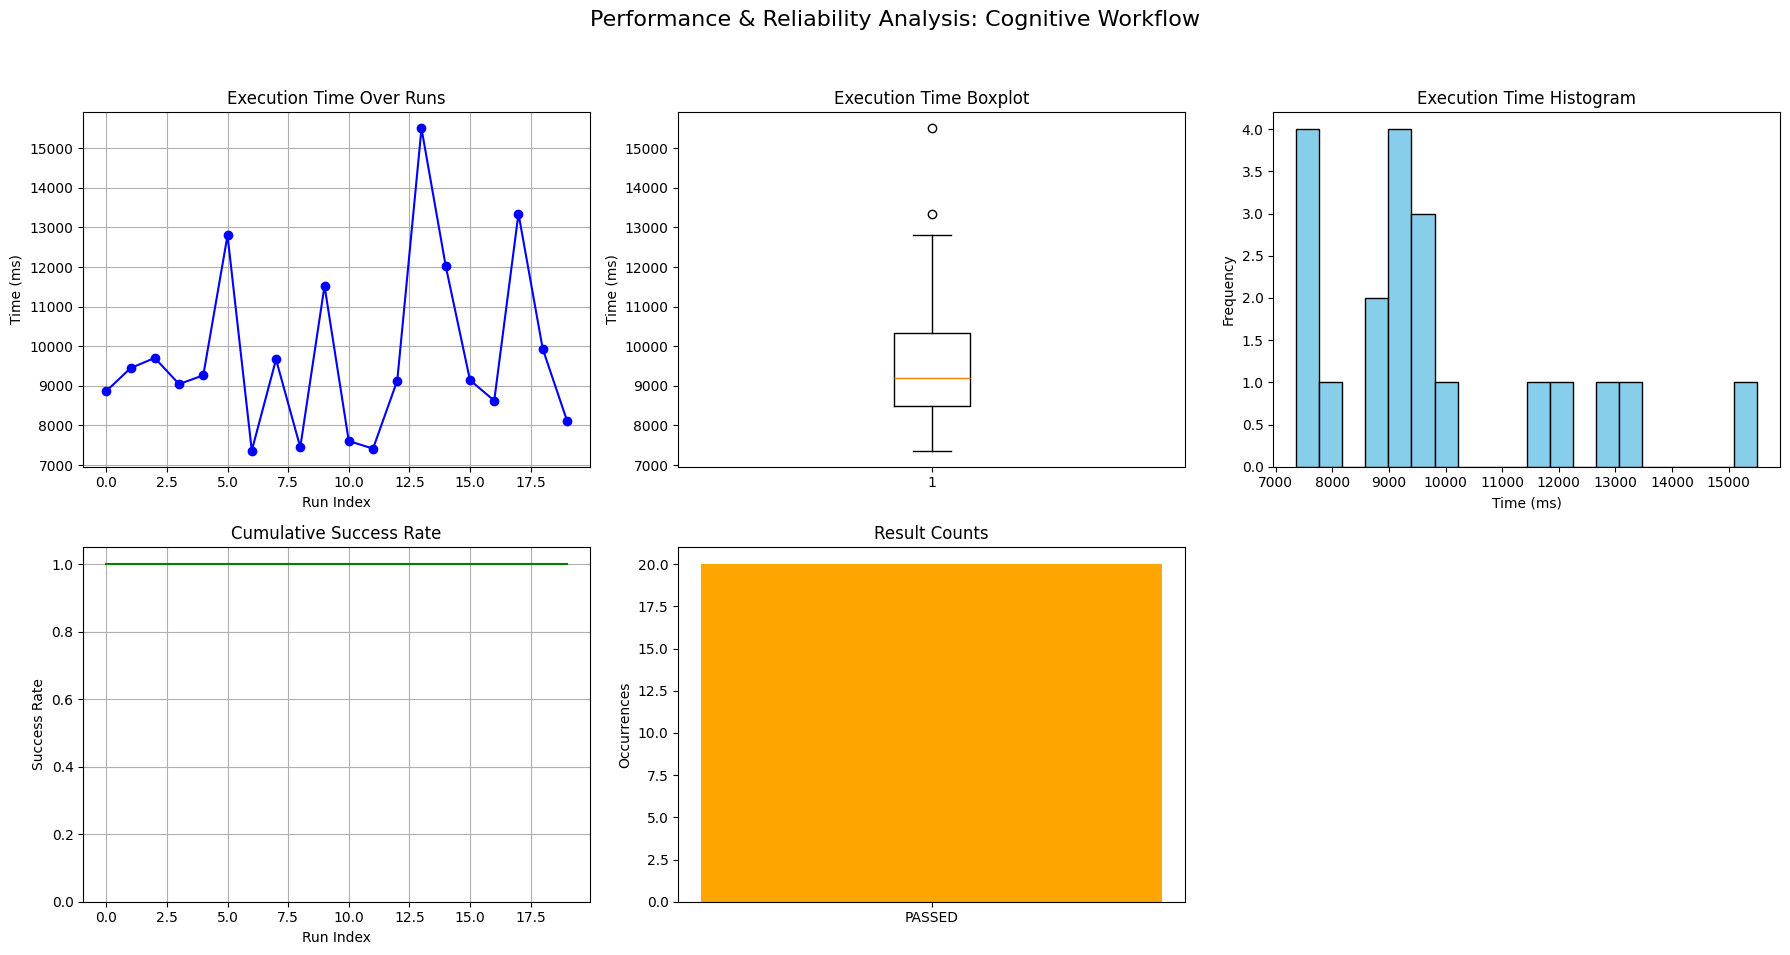

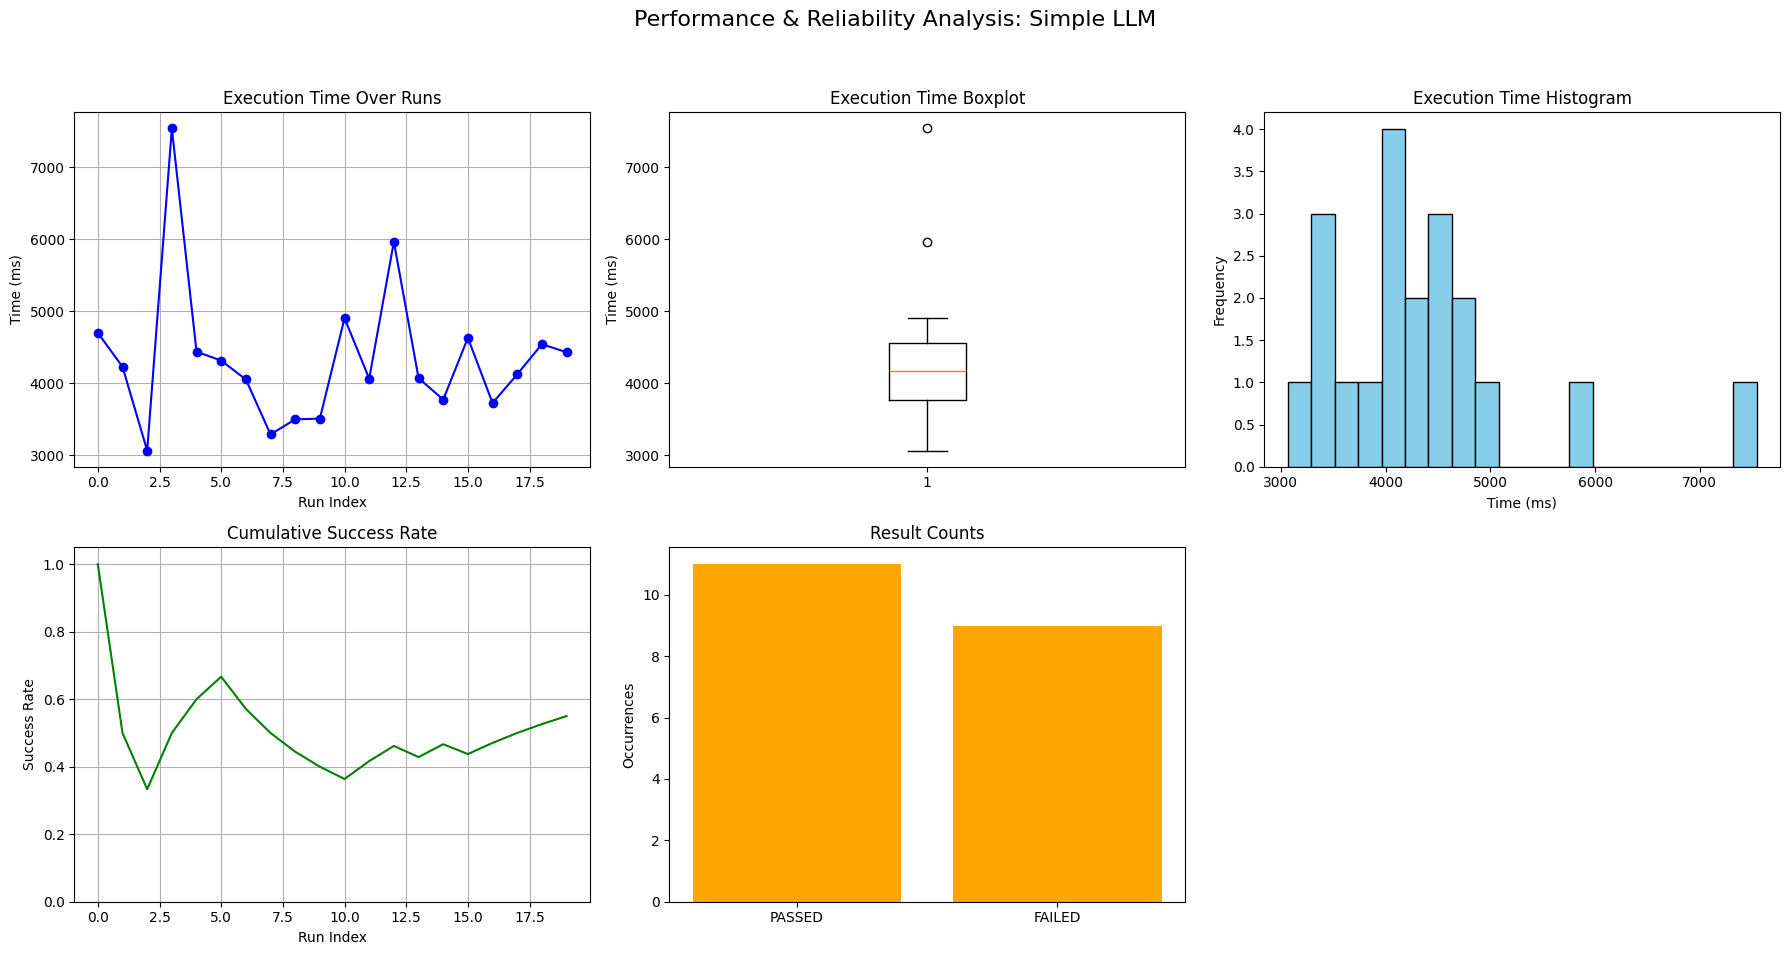

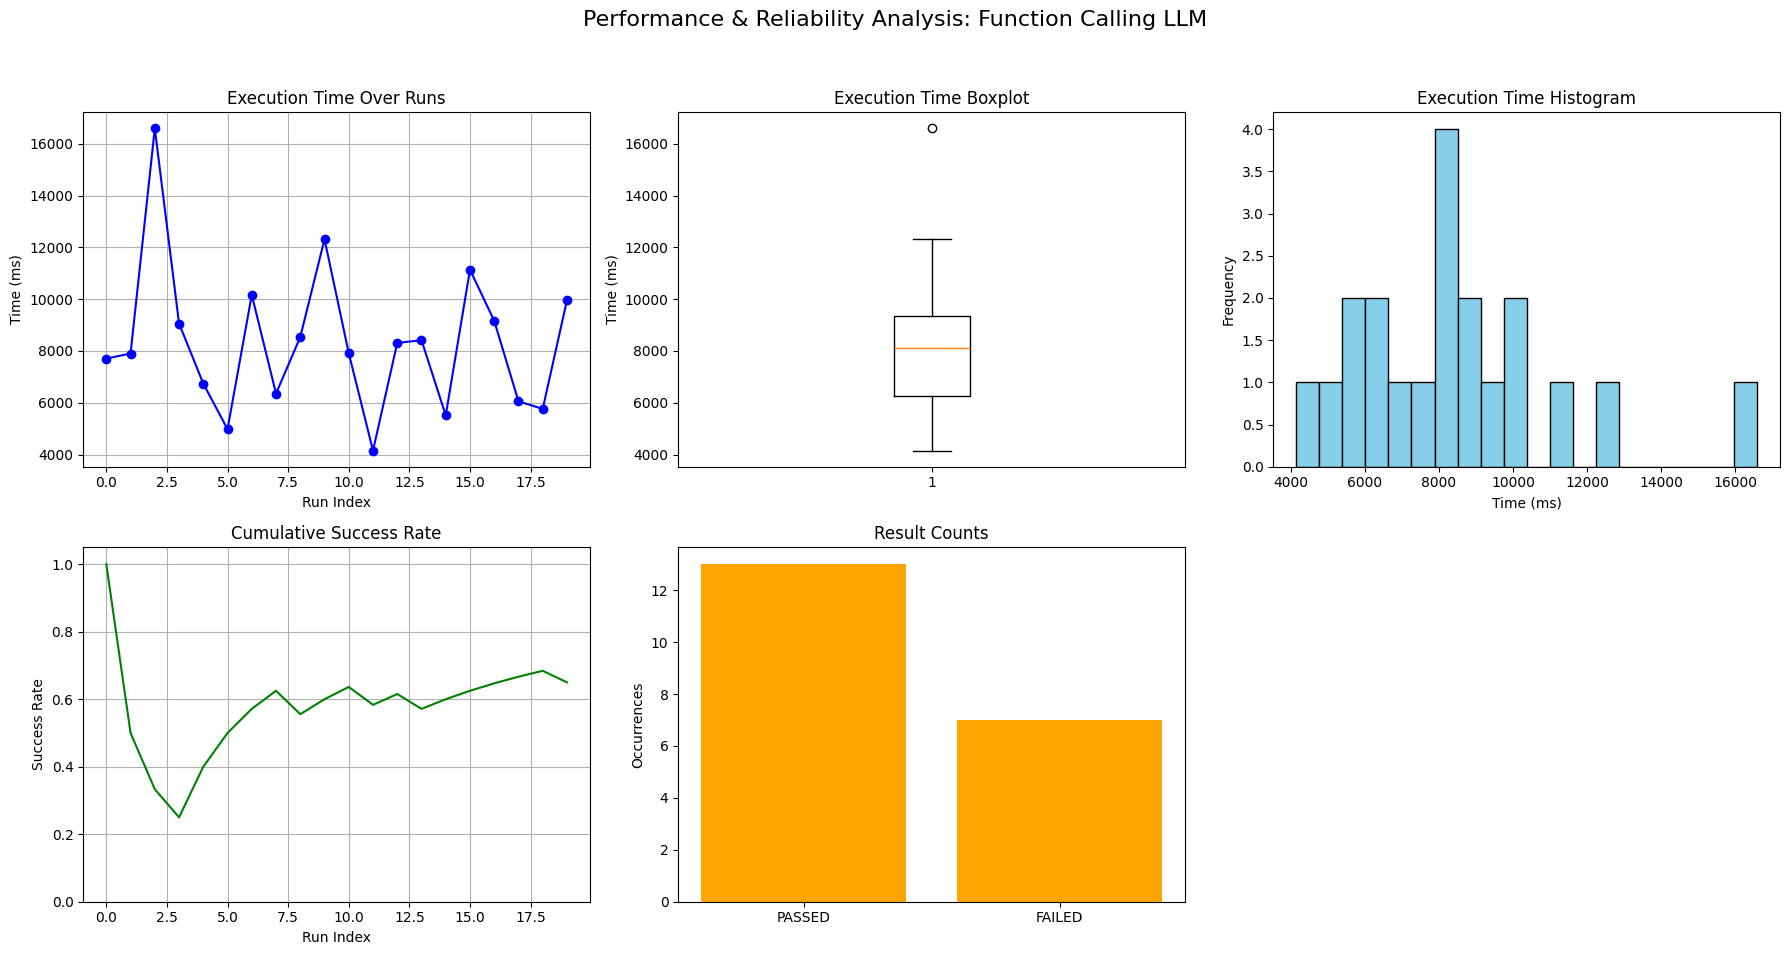

/var/folders/j2/g16nd4ld17z43clcp8bbjqv80000gn/T/ipykernel_2348/725331036.py:476: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax_boxplot.boxplot(times_all, vert=True, labels=all_labels, patch_artist=True)


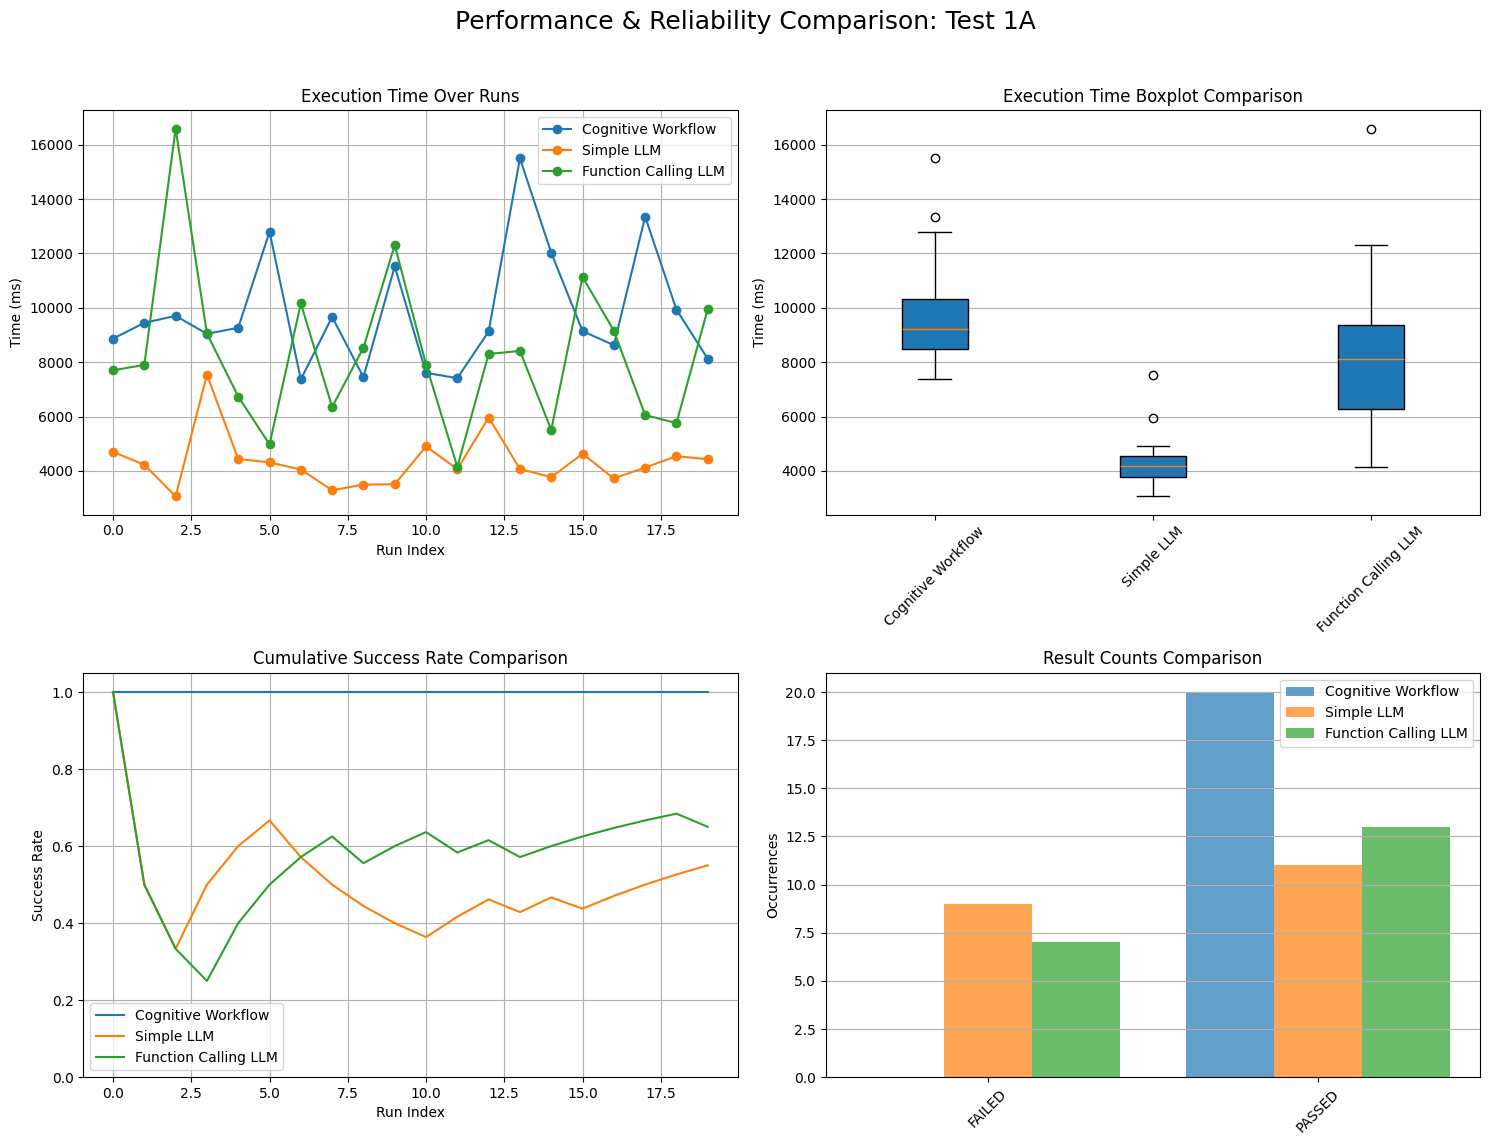

In [27]:
networkExperiment.experiment.plot_single_tests()
networkExperiment.experiment.plot_comparison()

# Test 1B: Sensor Fusion Data Processing

In [41]:
REQUEST_TEXT = "Configure a high-throughput network to process sensor fusion data from 500 Google Waymo autonomous vehicles for centralized AI training. Each vehicle streams 80 MB/s of LiDAR, camera, and radar data. A single processing node must ingest all incoming data streams, utilizing NVMe-over-Fabrics storage for training dataset ingestion and hardware-accelerated preprocessing before forwarding the data to downstream GPU training clusters."

RIGHT_ANSWER = ["1", "2", "3", "5"]

networkExperiment = NetworkExperiment("Test 1B", REQUEST_TEXT, RIGHT_ANSWER, 20)
networkExperiment.experiment.run_all_tests()

Starting Experiment: Test 1B
Running 3 tests

Test 1/3: Cognitive Workflow
------------------------------------------------------------
- Starting test: Cognitive Workflow
- Endpoint: http://localhost:3001/api/workflows/execute
- Request: Configure a high-throughput network to process sensor fusion data from 500 Google Waymo autonomous vehicles for centralized AI training. Each vehicle streams 80 MB/s of LiDAR, camera, and radar data. A single processing node must ingest all incoming data streams, utilizing NVMe-over-Fabrics storage for training dataset ingestion and hardware-accelerated preprocessing before forwarding the data to downstream GPU training clusters.
Starting warmup phase (1 requests)...
Warmup 1/1


KeyboardInterrupt: 

/var/folders/j2/g16nd4ld17z43clcp8bbjqv80000gn/T/ipykernel_2348/725331036.py:476: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax_boxplot.boxplot(times_all, vert=True, labels=all_labels, patch_artist=True)


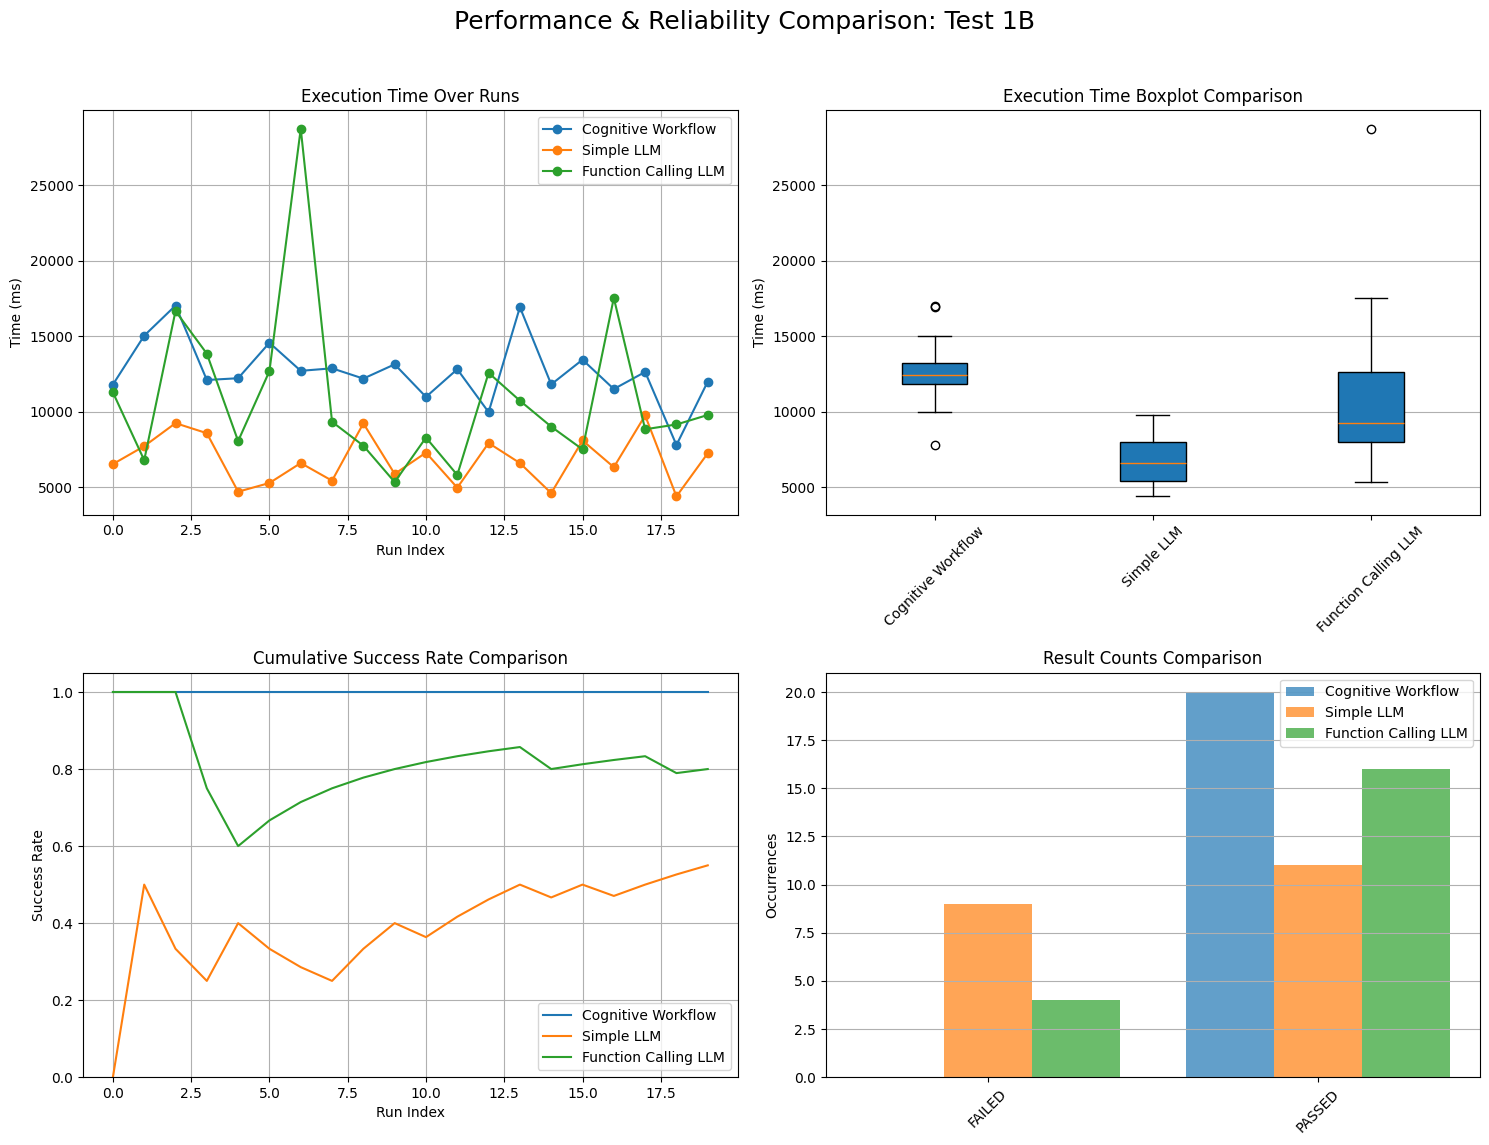

In [30]:
networkExperiment.experiment.plot_comparison()

This cell introduces the WorkflowObservabilityAnalyzer class, designed to extract and analyze execution times from the observability data of a workflow. This can be used to break down the performance of different stages within a complex workflow.

In [32]:
class WorkflowObservabilityAnalyzer:
    def __init__(self):
        self.observability_data = None

    def extract_execution_times(self, observability: Dict) -> Dict[str, float]:
        """Extract execution times from observability data"""
        execution_times = {}

        # Intent detection phase
        if 'intentDetection' in observability:
            intent_data = observability['intentDetection']
            execution_times['Intent Detection'] = intent_data.get('totalExecutionTime', 0)

        # Routing phase
        if 'routing' in observability:
            routing_data = observability['routing']
            execution_times['Routing'] = routing_data.get('totalExecutionTime', 0)

        # Input mapping phase
        if 'inputMapper' in observability:
            input_mapper_data = observability['inputMapper']
            execution_times['Input Mapping'] = input_mapper_data.get('totalExecutionTime', 0)

        # Workflow execution phase
        if 'workflowExecution' in observability:
            workflow_data = observability['workflowExecution']
            execution_times['Workflow Execution'] = workflow_data.get('totalExecutionTime', 0)

            # Individual node execution times
            if 'nodeExecutions' in workflow_data:
                node_times = {}
                for node_id, node_data in workflow_data['nodeExecutions'].items():
                    node_name = node_data.get('nodeName', f'Node {node_id}')
                    node_times[node_name] = node_data.get('executionTime', 0)
                execution_times['Node Executions'] = node_times

        return execution_times

    def plot_execution_times(self, execution_times: Dict, title: str = "Workflow Execution Time Distribution"):
        """Create comprehensive visualization of execution times"""
        # Set up the plotting style
        plt.style.use('seaborn-v0_8')
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        # 1. Main phases bar chart
        main_phases = {k: v for k, v in execution_times.items() if k != 'Node Executions'}
        if main_phases:
            phases = list(main_phases.keys())
            times = list(main_phases.values())

            bars = ax1.bar(phases, times, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
            ax1.set_title('Execution Time by Phase', fontweight='bold')
            ax1.set_ylabel('Time (ms)')
            ax1.tick_params(axis='x', rotation=45)

            # Add value labels on bars
            for bar, time in zip(bars, times):
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height + max(times)*0.01,
                        f'{time}ms', ha='center', va='bottom', fontweight='bold')

        # 2. Pie chart for phase distribution
        if main_phases:
            colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
            wedges, texts, autotexts = ax2.pie(times, labels=phases, autopct='%1.1f%%',
                                              colors=colors, startangle=90)
            ax2.set_title('Phase Time Distribution', fontweight='bold')

            # Enhance pie chart text
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')

        # 3. Node execution times
        if 'Node Executions' in execution_times:
            node_data = execution_times['Node Executions']
            if node_data:
                nodes = list(node_data.keys())
                node_times = list(node_data.values())

                bars = ax3.bar(nodes, node_times, color='#FFA07A')
                ax3.set_title('Node Execution Times', fontweight='bold')
                ax3.set_ylabel('Time (ms)')
                ax3.tick_params(axis='x', rotation=45)

                # Add value labels on bars
                for bar, time in zip(bars, node_times):
                    height = bar.get_height()
                    ax3.text(bar.get_x() + bar.get_width()/2., height + max(node_times)*0.01,
                            f'{time}ms', ha='center', va='bottom', fontweight='bold')

        # 4. Cumulative execution timeline
        if main_phases:
            cumulative_times = np.cumsum([0] + list(main_phases.values()))
            phase_names = ['Start'] + list(main_phases.keys())

            ax4.plot(range(len(cumulative_times)), cumulative_times,
                    marker='o', linewidth=3, markersize=8, color='#8E44AD')
            ax4.fill_between(range(len(cumulative_times)), cumulative_times, alpha=0.3, color='#8E44AD')
            ax4.set_title('Cumulative Execution Timeline', fontweight='bold')
            ax4.set_xlabel('Phase')
            ax4.set_ylabel('Cumulative Time (ms)')
            ax4.set_xticks(range(len(phase_names)))
            ax4.set_xticklabels(phase_names, rotation=45)
            ax4.grid(True, alpha=0.3)

            # Add annotations for each phase
            for i, (phase, cum_time) in enumerate(zip(phase_names[1:], cumulative_times[1:]), 1):
                ax4.annotate(f'{cum_time}ms', (i, cum_time),
                           textcoords="offset points", xytext=(0,10), ha='center',
                           fontweight='bold', fontsize=9)

        plt.tight_layout()
        return fig

    def generate_performance_summary(self, execution_times: Dict) -> str:
        """Generate a text summary of performance metrics"""
        summary = []
        summary.append("=== WORKFLOW PERFORMANCE SUMMARY ===\n")

        # Main phases analysis
        main_phases = {k: v for k, v in execution_times.items() if k != 'Node Executions'}
        if main_phases:
            total_time = sum(main_phases.values())
            summary.append(f"Total Execution Time: {total_time}ms ({total_time/1000:.2f}s)\n")

            summary.append("Phase Breakdown:")
            for phase, time in main_phases.items():
                percentage = (time / total_time) * 100
                summary.append(f"  • {phase}: {time}ms ({percentage:.1f}%)")

            # Identify bottleneck
            slowest_phase = max(main_phases.items(), key=lambda x: x[1])
            summary.append(f"\nBottleneck: {slowest_phase[0]} ({slowest_phase[1]}ms)")

        # Node analysis
        if 'Node Executions' in execution_times:
            node_data = execution_times['Node Executions']
            if node_data:
                summary.append(f"\nNode Execution Details:")
                summary.append(f"  • Total Nodes: {len(node_data)}")

                avg_node_time = np.mean(list(node_data.values()))
                summary.append(f"  • Average Node Time: {avg_node_time:.1f}ms")

                slowest_node = max(node_data.items(), key=lambda x: x[1])
                summary.append(f"  • Slowest Node: {slowest_node[0]} ({slowest_node[1]}ms)")

                fastest_node = min(node_data.items(), key=lambda x: x[1])
                summary.append(f"  • Fastest Node: {fastest_node[0]} ({fastest_node[1]}ms)")

        return "\n".join(summary)

# TEST 1C: Observability

- Starting test: Workflow Observability Test
- Endpoint: http://localhost:3001/api/workflows/execute
- Request: Configure a high-throughput network to process sensor fusion data from 500 Google Waymo autonomous vehicles for centralized AI training. Each vehicle streams 80 MB/s of LiDAR, camera, and radar data. A single processing node must ingest all incoming data streams, utilizing NVMe-over-Fabrics storage for training dataset ingestion and hardware-accelerated preprocessing before forwarding the data to downstream GPU training clusters.
Starting warmup phase (0 requests)...
✓ Warmup phase complete.

Starting test phase (1 successful requests targeted)...
Request 1/1
✗ Invalid response [{'output': {'path': ['1', '2', '3', '5']}, 'observability': {'intentDetection': {'inputRequest': 'Configure a high-throughput network to process sensor fusion data from 500 Google Waymo autonomous vehicles for centralized AI training. Each vehicle streams 80\u202fMB/s of LiDAR, camera, and radar data.

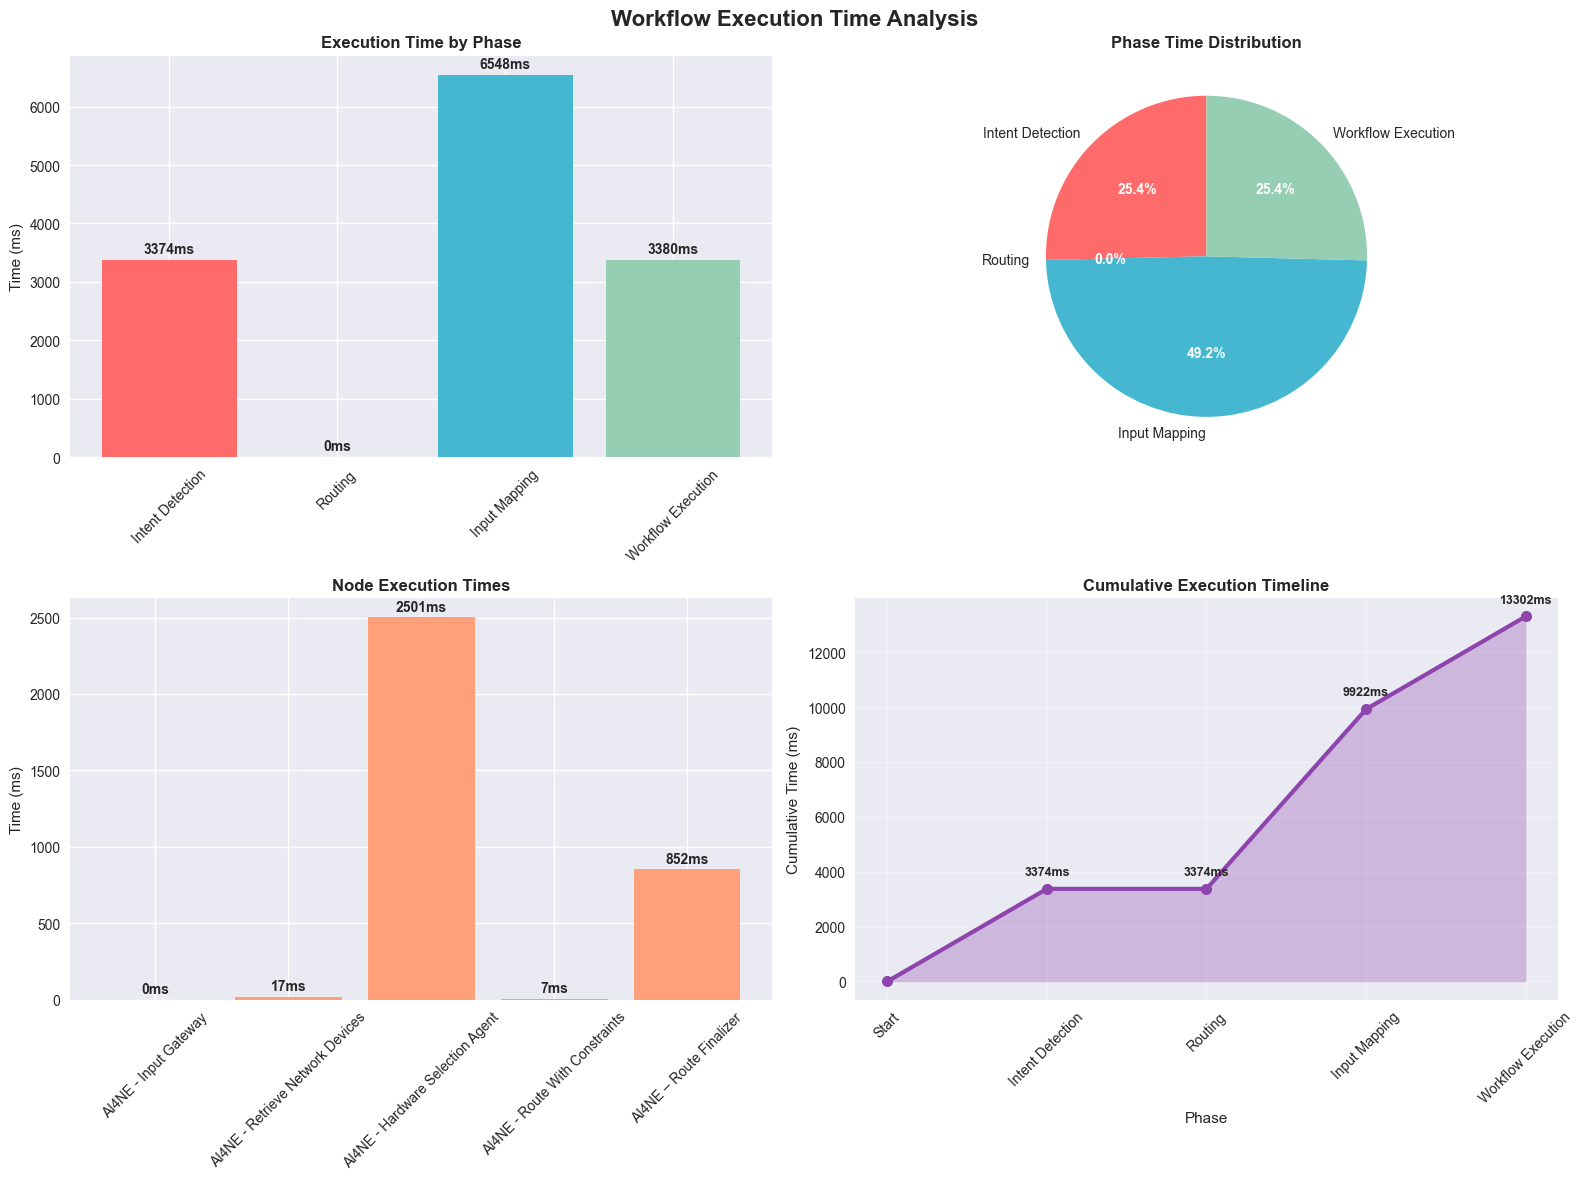

In [33]:
REQUEST_TEXT = "Configure a high-throughput network to process sensor fusion data from 500 Google Waymo autonomous vehicles for centralized AI training. Each vehicle streams 80 MB/s of LiDAR, camera, and radar data. A single processing node must ingest all incoming data streams, utilizing NVMe-over-Fabrics storage for training dataset ingestion and hardware-accelerated preprocessing before forwarding the data to downstream GPU training clusters."

RIGHT_ANSWER = ["1", "2", "3", "5"]

result = {"observability": None}

def validator(answer: dict):
    if not answer:
        return ResultStatus.FAILED

    path = answer.get("output", {}).get("path")
    result["observability"] = answer.get("observability")

    if path is None:
        return ResultStatus.FAILED

    if path != RIGHT_ANSWER:
        return ResultStatus.FAILED
    return ResultStatus.PASSED

test = Test("Workflow Observability Test", COGNITIVE_WORKFLOW_URL, REQUEST_TEXT, validator, 1, 0,
            additional_payload={"observability": True})
test.run()

analyzer = WorkflowObservabilityAnalyzer()

execution_times = analyzer.extract_execution_times(result["observability"])
summary = analyzer.generate_performance_summary(execution_times)
print("\n" + summary)
fig = analyzer.plot_execution_times(execution_times, "Workflow Execution Time Analysis")
plt.show()

# Test 1D

In [42]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class ExperimentsBatch:
    def __init__(self, experiment_batch: List[Tuple[str, List[str]]], num_requests: int = 20):
        self.experiment_batch = experiment_batch
        self.num_requests = num_requests
        self.experiments = []
        self.batch_results = {}
        self.prompt_mapping = {}

        for i, (prompt, expected_answer) in enumerate(experiment_batch):
            experiment_name = f"Experiment_{i+1}"
            prompt_key = f"Prompt {i+1}"

            self.prompt_mapping[prompt_key] = prompt

            experiment = NetworkExperiment(
                test_name=experiment_name,
                request_text=prompt,
                expected_answer=expected_answer,
                num_requests=num_requests,
                num_warmup_requests=0
            )

            self.experiments.append({
                'experiment': experiment,
                'prompt': prompt,
                'expected_answers': expected_answer,
                'name': experiment_name,
                'prompt_key': prompt_key
            })

    def run_all_experiments(self):
        print(f"Starting batch execution of {len(self.experiments)} experiments")
        print("=" * 80)

        for i, exp_data in enumerate(self.experiments, 1):
            print(f"\n📊 Running Experiment {i}/{len(self.experiments)}")
            print(f"Prompt: {exp_data['prompt']}")

            results = exp_data['experiment'].experiment.run_all_tests()

            self.batch_results[exp_data['name']] = {
                'prompt': exp_data['prompt'],
                'prompt_key': exp_data['prompt_key'],
                'results': results
            }

            print(f"Experiment {i} completed")

        print(f"\nAll {len(self.experiments)} experiments completed!")
        self._print_batch_summary()

    def _print_batch_summary(self):
        print("\n" + "=" * 80)
        print("BATCH EXPERIMENT SUMMARY")
        print("=" * 80)

        for exp_name, exp_data in self.batch_results.items():
            print(f"\n{exp_name}")
            print(f"   Request: {exp_data['prompt']}")

            for test_name, test_results in exp_data['results'].items():
                if test_results:
                    passed = sum(1 for r in test_results if r.status.value == "PASSED")
                    total = len(test_results)
                    success_rate = (passed / total) * 100 if total > 0 else 0
                    print(f"   └─ {test_name}: {success_rate:.1f}% success ({passed}/{total})")

    def get_prompt_mapping_table(self):
        mapping_data = []
        for prompt_key, full_prompt in self.prompt_mapping.items():
            mapping_data.append({
                'Prompt Key': prompt_key,
                'Full Prompt Text': full_prompt
            })

        df = pd.DataFrame(mapping_data)
        return df

    def get_results_dataframe(self):
        if not self.batch_results:
            print("No results available. Run experiments first.")
            return None

        data = []

        for exp_name, exp_data in self.batch_results.items():
            row = {
                'Prompt Key': exp_data['prompt_key'],
                'Full Prompt Text': exp_data['prompt']
            }

            for test_name, test_results in exp_data['results'].items():
                if test_results:
                    passed = sum(1 for r in test_results if r.status.value == "PASSED")
                    total = len(test_results)
                    success_rate = (passed / total) * 100 if total > 0 else 0
                    row[f"{test_name} (%)"] = f"{success_rate:.1f}%"
                    row[f"{test_name} (Count)"] = f"{passed}/{total}"
                else:
                    row[f"{test_name} (%)"] = "0.0%"
                    row[f"{test_name} (Count)"] = "0/0"

            data.append(row)

        return pd.DataFrame(data)

    def display_results_table(self):
        df = self.get_results_dataframe()
        if df is not None:
            try:
                from IPython.display import display
                pd.set_option('display.max_colwidth', None)
                pd.set_option('display.width', None)
                pd.set_option('display.max_columns', None)
                display(df)
            except ImportError:
                print("\n" + "=" * 150)
                print("COMPREHENSIVE RESULTS TABLE")
                print("=" * 150)
                print(df.to_string(index=False))
                print("=" * 150)


    def plot_success_rates(self, figsize=(14, 8)):
        if not self.batch_results:
            print("No results to plot. Run experiments first.")
            return

        prompt_keys = []
        success_rates = defaultdict(dict)

        for exp_data in self.batch_results.values():
            prompt_key = exp_data['prompt_key']
            prompt_keys.append(prompt_key)

            for test_name, test_results in exp_data['results'].items():
                if test_results:
                    passed = sum(1 for r in test_results if r.status.value == "PASSED")
                    total = len(test_results)
                    success_rate = (passed / total) * 100 if total > 0 else 0
                    success_rates[test_name][prompt_key] = success_rate
                else:
                    success_rates[test_name][prompt_key] = 0

        test_categories = sorted(list(success_rates.keys()))

        fig, ax = plt.subplots(figsize=figsize)

        n_prompts = len(prompt_keys)
        n_tests = len(test_categories)
        bar_width = 0.25
        x = np.arange(n_prompts)

        colors = plt.colormaps['tab10'].colors

        for i, test_name in enumerate(test_categories):
            values = [success_rates[test_name].get(prompt_key, 0) for prompt_key in prompt_keys]
            offset = (i - (n_tests-1)/2) * bar_width
            bars = ax.bar(x + offset, values, bar_width, label=test_name,
                         color=colors[i % len(colors)], alpha=0.8, edgecolor='black', linewidth=0.5)

        ax.set_xlabel('Experiment Prompts', fontsize=12, fontweight='bold')
        ax.set_ylabel('Success Rate (%)', fontsize=12, fontweight='bold')
        ax.set_title('Success Rate Comparison Across Different Approaches',
                    fontsize=14, fontweight='bold', pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels(prompt_keys, fontsize=11, fontweight='bold')
        ax.legend(title='Approaches', title_fontsize=12, fontsize=10,
                 bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, axis='y', alpha=0.3)
        ax.set_ylim(0, 120)  # Increased to accommodate stacked labels

        # Add horizontal line at 100%
        ax.axhline(y=100, color='red', linestyle='--', alpha=0.5, linewidth=1)

        plt.tight_layout()
        plt.show()


        try:
            self.display_results_table()
        except ImportError:
              self.display_results_table()



In [49]:
DPU_PATH = ["1", "2", "3", "5"]
MODEM_PATH = ["1", "2", "4", "5"]
EDGE_PATH = MODEM_PATH


experiment_batch = [
    # DPU scenarios
    (
        "Enterprise data center requires 200 Gbps bandwidth for real-time financial trading with sub-millisecond latency. AC power available. No mobility required.",
        DPU_PATH
    ),

    (
        "Scientific computing cluster needs to transfer 150 Gbps of simulation data with latency under 1ms. Fixed installation in research facility.",
        DPU_PATH
    ),

    # Clear Modem scenarios
    (
        "Mobile autonomous vehicle needs real-time AI-powered object recognition with 5G connectivity. Must operate on battery power while moving.",
        MODEM_PATH
    ),

    (
        "Portable medical device requires AI-assisted diagnosis with 5G upload to cloud. Battery-powered, must work during patient transport.",
        MODEM_PATH
    ),

    #  Edge scenarios
    (
        "Remote environmental sensor network needs 10-year battery life, 100 Kbps data rate, powered by small solar panel in remote location.",
        EDGE_PATH
    ),

    (
        "Wearable health monitor requires continuous operation for 1 week on single charge, 1 Mbps data rate, embedded in clothing.",
        EDGE_PATH
    ),

    # Constraint-based scenarios that eliminate alternatives
    (
        "Application requires exactly 50 Gbps bandwidth. Device must consume less than 10W power. Location has only battery power available.",
        MODEM_PATH
    ),

    (
        "System must process AI workloads while consuming under 10W power and supporting mobile 5G connectivity.",
        MODEM_PATH
    ),

    # Bandwidth elimination scenarios
    (
        "Application needs minimum 100 Gbps throughput for video processing. Power and mobility are not constraints.",
        DPU_PATH
    ),

    (
        "IoT sensor needs maximum 500 Kbps bandwidth and must run on coin cell battery for 5+ years.",
        EDGE_PATH
    )
]





experiment_batch_shuffled = experiment_batch.copy()
shuffle(experiment_batch_shuffled)
batch = ExperimentsBatch(experiment_batch_shuffled, num_requests=4)
batch.run_all_experiments()

Starting batch execution of 10 experiments

📊 Running Experiment 1/10
Prompt: SCENARIO: Application needs minimum 100 Gbps throughput for video processing. Power and mobility are not constraints.
Starting Experiment: Experiment_1
Running 3 tests

Test 1/3: Cognitive Workflow
------------------------------------------------------------
- Starting test: Cognitive Workflow
- Endpoint: http://localhost:3001/api/workflows/execute
- Request: SCENARIO: Application needs minimum 100 Gbps throughput for video processing. Power and mobility are not constraints.
Starting warmup phase (0 requests)...
✓ Warmup phase complete.

Starting test phase (4 successful requests targeted)...
Request 1/4
✓ Valid response [{'path': ['1', '2', '3', '5']}]
Request 2/4
✓ Valid response [{'path': ['1', '2', '3', '5']}]
Request 3/4
✓ Valid response [{'path': ['1', '2', '3', '5']}]
Request 4/4
✓ Valid response [{'path': ['1', '2', '3', '5']}]

Test Summary for: Cognitive Workflow
- PASSED: 4
- FAILED: 0
- Total: 4
-

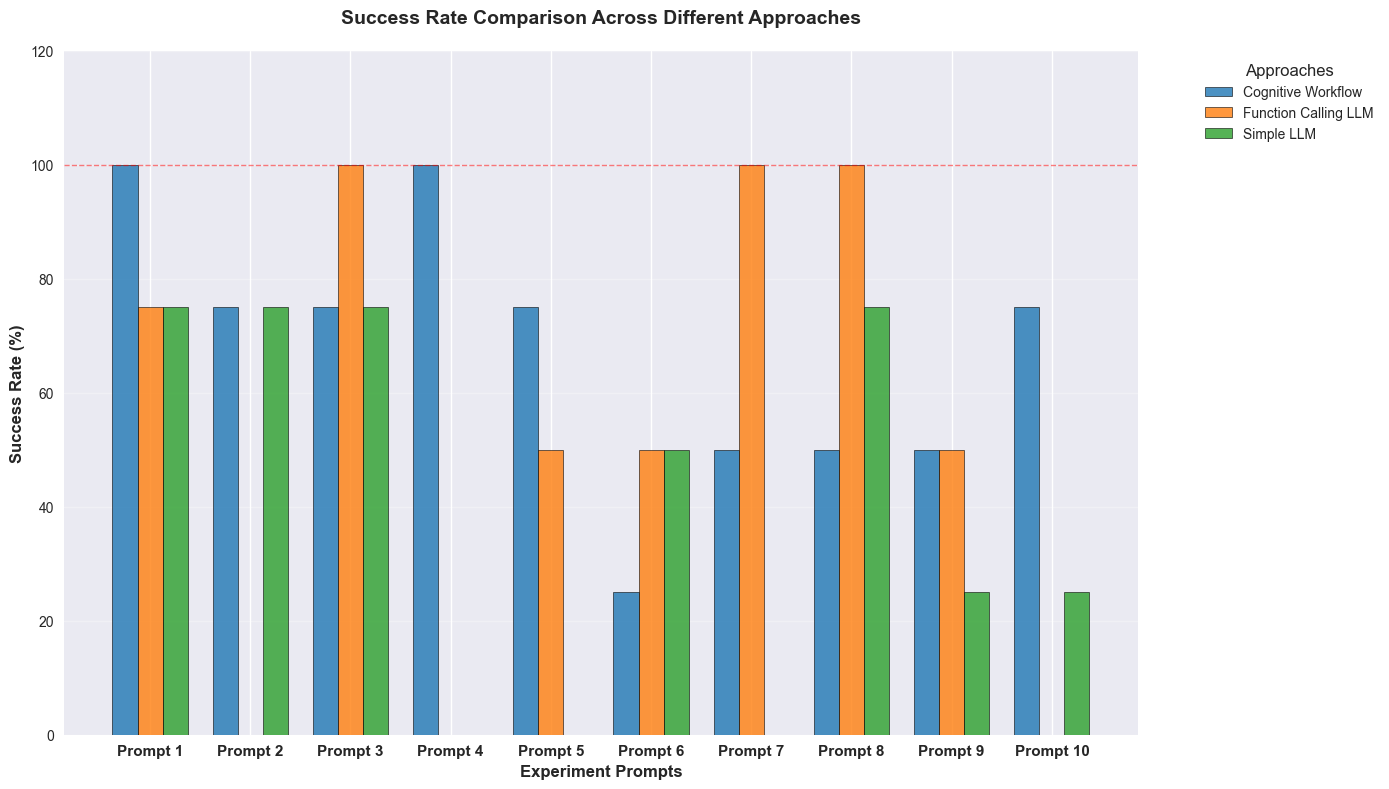

,Prompt Key,Full Prompt Text,Cognitive Workflow (%),Cognitive Workflow (Count),Simple LLM (%),Simple LLM (Count),Function Calling LLM (%),Function Calling LLM (Count)
0,Prompt 1,SCENARIO: Application needs minimum 100 Gbps throughput for video processing. Power and mobility are not constraints.,100.0%,4/4,75.0%,3/4,75.0%,3/4
1,Prompt 2,"SCENARIO: Portable medical device requires AI-assisted diagnosis with 5G upload to cloud. Battery-powered, must work during patient transport.",75.0%,3/4,75.0%,3/4,0.0%,0/4
2,Prompt 3,SCENARIO: Scientific computing cluster needs to transfer 150 Gbps of simulation data with latency under 1ms. Fixed installation in research facility.,75.0%,3/4,75.0%,3/4,100.0%,4/4
3,Prompt 4,SCENARIO: Application requires exactly 50 Gbps bandwidth. Device must consume less than 10W power. Location has only battery power available.,100.0%,4/4,0.0%,0/4,0.0%,0/4
4,Prompt 5,SCENARIO: System must process AI workloads while consuming under 10W power and supporting mobile 5G connectivity.,75.0%,3/4,0.0%,0/4,50.0%,2/4
5,Prompt 6,SCENARIO: Mobile autonomous vehicle needs real-time AI-powered object recognition with 5G connectivity. Must operate on battery power while moving.,25.0%,1/4,50.0%,2/4,50.0%,2/4
6,Prompt 7,"SCENARIO: Wearable health monitor requires continuous operation for 1 week on single charge, 1 Mbps data rate, embedded in clothing.",50.0%,2/4,0.0%,0/4,100.0%,4/4
7,Prompt 8,SCENARIO: Enterprise data center requires 200 Gbps bandwidth for real-time financial trading with sub-millisecond latency. AC power available. No mobility required.,50.0%,2/4,75.0%,3/4,100.0%,4/4
8,Prompt 9,"SCENARIO: Remote environmental sensor network needs 10-year battery life, 100 Kbps data rate, powered by small solar panel in remote location.",50.0%,2/4,25.0%,1/4,50.0%,2/4
9,Prompt 10,SCENARIO: IoT sensor needs maximum 500 Kbps bandwidth and must run on coin cell battery for 5+ years.,75.0%,3/4,25.0%,1/4,0.0%,0/4


In [50]:
batch.plot_success_rates()